In [2]:
!pip install --upgrade scikit-learn==0.20.3

     |████████████████████████████████| 5.4 MB 9.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.3 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE 
import seaborn as sns
import time
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


def readDataset():
	# Đọc dataset
	data = pd.read_csv("bank-full.csv")
	data = data.dropna()

	# Row: 41188 record - col: 21 fields
	# print(data.shape)

	# Tiêu đề
	# print(list(data.columns))

	# In 5 dòng đầu
	# print(data.head())

	# Dữ liệu cột education
	# print(data['education'].unique())

	# Nhóm dữ liệu basic.4y - basic.6y - basic.9y thành basic

	data['education'] = np.where(data['education'] == 'basic.4y','basic',data['education'])
	data['education'] = np.where(data['education'] == 'basic.6y','basic',data['education'])
	data['education'] = np.where(data['education'] == 'basic.9y','basic',data['education'])

	# Kiểm tra:
	# print(data['education'].unique())
	return data

# Tỉ lệ phần trăm của khách hàng đăng ký và không đăng ký
def subscriptionPercent(data):
	# Tỉ lệ phần trăm những khách hàng đăng ký
	count = len(data['y'])
	count_sub = len(data[data['y']==0])
	count_no_sub = len(data[data['y']==1])

	sub_percent = count_sub/count
	no_sub_percent = count_no_sub/count

	print('tỉ lệ phần trăm khách hàng đăng ký:',round(sub_percent * 100,2),'%')
	print('tỉ lệ phần trăm khách hàng không đăng ký:',round(no_sub_percent * 100,2),'%')

	# Trung bình theo biến phân loại y:
	# print(data.groupby('y').mean())

def numberVariable(data):
	# Chuyển đổi biến chuỗi thành các cột chứa dữ liệu dạng binary (có hoặc không)
	# vd: marital : married -> marital_married : 1 nếu khách hàng đó có kết hôn hay marital_married : 0 nếu khách hàng ko có kết hôn
	vars = ['job','sex','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
	for var in vars:
	    cat_list = 'var' + '_' + var
	    cat_list = pd.get_dummies(data[var], prefix = var)
	    data1 = data.join(cat_list)
	    data = data1
	vars = ['job','sex','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
	data_vars = data.columns.values.tolist()
	to_keep = [i for i in data_vars if i not in vars]
	data_final = data[to_keep]
	# Test title dataset
	# print(data_final.columns.values)
	# print(data_final.head(5))
	return data_final

In [4]:
# xử lý dữ liệu: do dataset majority chiếm phần lớn nên ta phải cân bằng minority có lượng dữ liệu như nhau.
# Sau đó train mô hình ở tập dữ liệu mới này.
def createSmote(data_final):
	# Oversampling: 
	# Tạo dữ liệu giả cho tập minority sao cho số phần tử của nó được nhiều lên.
	# Cách đơn giản nhất là lặp lại mỗi điểm trong minority nhiều lần.
	# tránh trường hợp khi phân training test chỉ tách ra majority -> gây sai lệch kết quả kiểm tra độ chính xác
	# ================================================================
	# SMOTE:
	# Với mỗi điểm trong tập minority, tìm k điểm cùng trong minority gần nó nhất rồi dùng tổng có trọng số của các điểm này để tạo ra các điểm dữ liệu mới. 
	
	# Test new dataset
	# print(data_final)
	# Lấy tất cả biến bỏ biến phân loại y
	X = data_final.loc[:, data_final.columns != 'y']
	# Lấy biến phân loại y
	y = data_final.loc[:, data_final.columns == 'y']
	os = SMOTE(random_state=0)
	# Phân data thành 2 phần: training data và testing data -> 30% Test - 70% train
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

	# test length Training data, Testing data
	print('Số lượng tập train:',len(X_train))
	print('Số lượng tập test:',len(X_test))
	# title dataset
	feature_rol = X_train.columns

	# dữ liệu được tạo ra hơn 10000 điểm dữ liệu mới
	os_data_X,os_data_y = os.fit_resample(X_train, y_train)

	os_data_X = pd.DataFrame(data = os_data_X,columns = feature_rol)

	os_data_y = pd.DataFrame(data = os_data_y,columns = ['y'])
	# Kiểm tra dữ liệu
	print('length Oversampling:',len(os_data_X))
	print('Số lượng khách hàng không đăng ký trong tập Oversampling:',len(os_data_y[os_data_y['y']==0]))
	print('Số lượng khách hàng đăng ký trong tập Oversampling:',len(os_data_y[os_data_y['y']==1]))
	print('Tỉ lệ khách hàng không đăng ký trong tập Oversampling:',len(os_data_y[os_data_y['y']==0])/len(os_data_X))
	print('Tỉ lệ khách hàng đăng ký trong tập Oversampling:',len(os_data_y[os_data_y['y']==1])/len(os_data_X))
	# Dữ liệu sau khi Oversampling dựa trên dữ liệu tập train data, do đó không có thông tin nào dựa vào tập test data
	# Kết quả dự đoán sẽ được chính xác
	return os_data_X,os_data_y,X_test,y_test

In [5]:
print('=======================================================')
print('------------Percentage------------')
data = readDataset()
subscriptionPercent(data)
print('=======================================================')
print('------------Oversampling - SMOTE------------')
# Decision Tree
data_final = numberVariable(data)
X_train,y_train,X_test,y_test = createSmote(data_final)
start_time = time.time()
print('=======================================================')
print('------------Decision tree------------')
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(X_train, y_train.values.ravel())
print('Độ chính xác: ',round(metrics.accuracy_score(y_test, model.predict(X_test)),2)*100,'%')
print(" Kết thúc: ",time.time()-start_time," seconds")

------------Percentage------------
tỉ lệ phần trăm khách hàng đăng ký: 88.73 %
tỉ lệ phần trăm khách hàng không đăng ký: 11.27 %
------------Oversampling - SMOTE------------
Số lượng tập train: 28831
Số lượng tập test: 12357
length Oversampling: 51134
Số lượng khách hàng không đăng ký trong tập Oversampling: 25567
Số lượng khách hàng đăng ký trong tập Oversampling: 25567
Tỉ lệ khách hàng không đăng ký trong tập Oversampling: 0.5
Tỉ lệ khách hàng đăng ký trong tập Oversampling: 0.5
------------Decision tree------------
Độ chính xác:  86.0 %
 Kết thúc:  0.2899928092956543  seconds


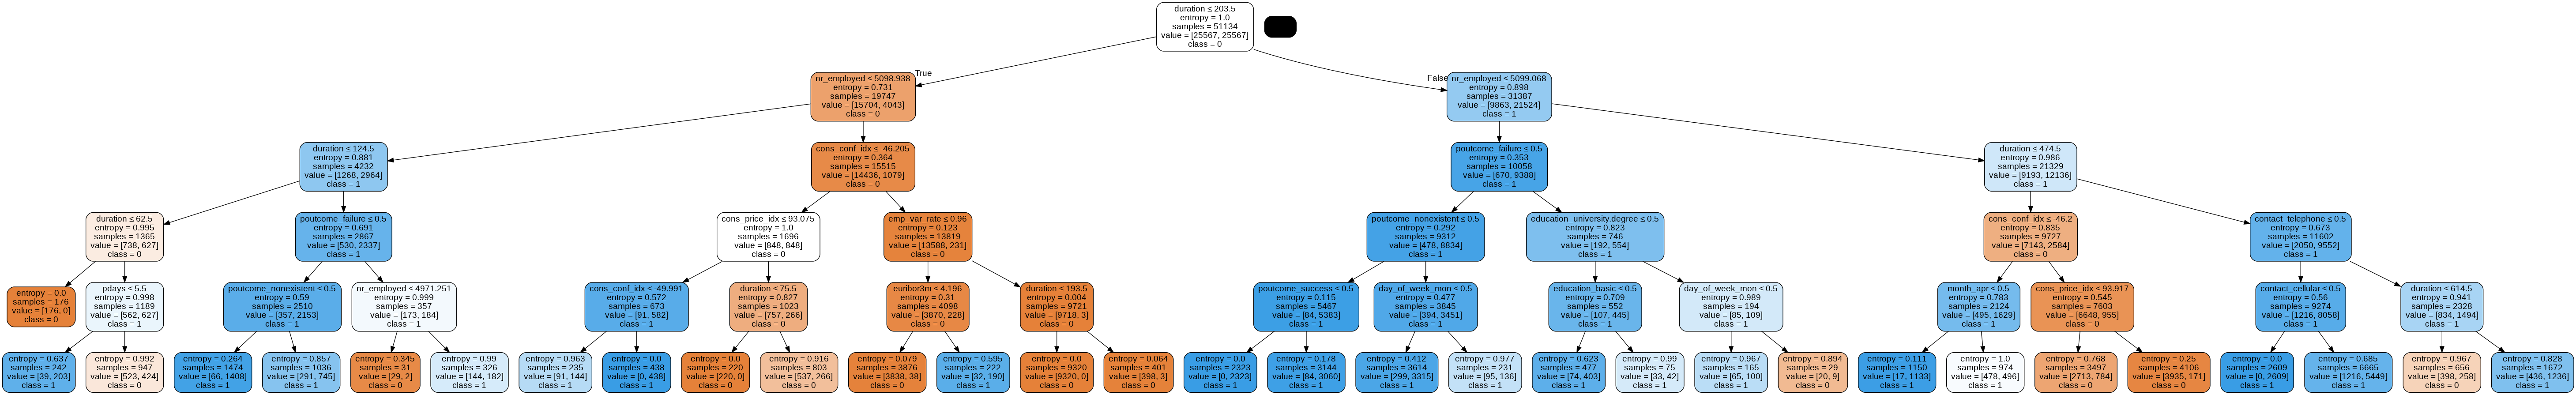

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
feature_cols = data_final.columns.values
indices = np.where(feature_cols=='y')
feature_cols= np.delete(feature_cols, indices)
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Trees.png')
Image(graph.create_png())

In [7]:
print('=======================================================')
print('------------Percentage------------')
data = readDataset()
subscriptionPercent(data)
print('=======================================================')
print('------------NO oversampling------------')
# Decision tree
data_final = numberVariable(data)
# Lấy tất cả biến bỏ biến phân loại y
X = data_final.loc[:, data_final.columns != 'y']
# Lấy biến phân loại y
y = data_final.loc[:, data_final.columns == 'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# test length Training data, Testing data
print('Số lượng tập train:',len(X_train))
print('Số lượng tập test:',len(X_test))
print('=======================================================')
print('------------Decision tree------------')
start_time = time.time()
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(X_train, y_train.values.ravel())
print('Độ chính xác: ',round(metrics.accuracy_score(y_test, model.predict(X_test)),2)*100,'%')
print(" Kết thúc: ",time.time()-start_time," seconds")

------------Percentage------------
tỉ lệ phần trăm khách hàng đăng ký: 88.73 %
tỉ lệ phần trăm khách hàng không đăng ký: 11.27 %
------------NO oversampling------------
Số lượng tập train: 28831
Số lượng tập test: 12357
------------Decision tree------------
Độ chính xác:  92.0 %
 Kết thúc:  0.12302064895629883  seconds


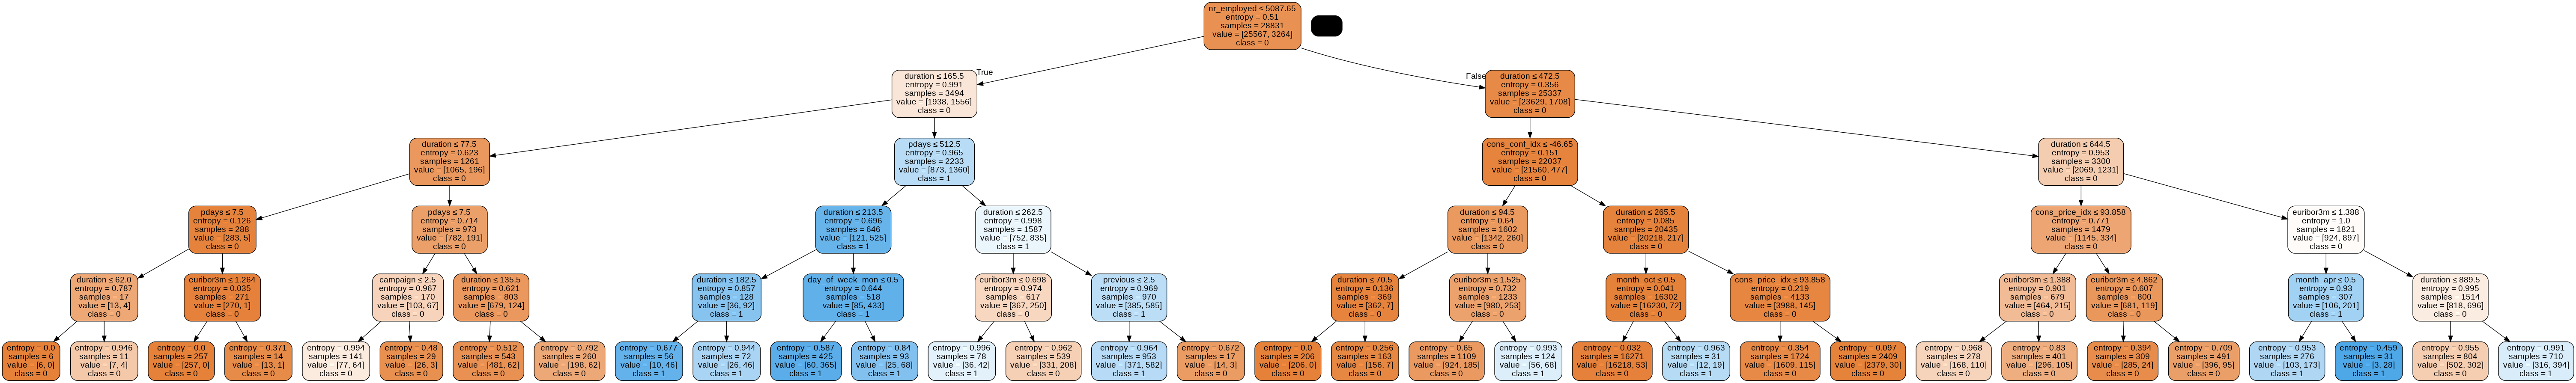

In [8]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
feature_cols = data_final.columns.values
indices = np.where(feature_cols=='y')
feature_cols= np.delete(feature_cols, indices)
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Trees_no_oversampling.png')
Image(graph.create_png())